# Faostat global model
In this notebook we create an ensemble of multilayer perceptron ([MLP](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)) models to fit the world crop yields using the input variables: precipitation, air temperature, natural and synthetic fertilizers.

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score 
from time import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import dates
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("Matplotlib version: %s"%mpl.__version__)

NumPy version: 1.25.2
Pandas version: 2.1.1
Matplotlib version: 3.8.0


## The dataset
We load the dataset that was prepared by putting into the same file the predictors and the predictands data

In [4]:
global_crop_yield_path = 'data/global_dataset.csv'
global_crop_yield_df = pd.read_csv(global_crop_yield_path, index_col=0)
global_crop_yield_df.head(2)

,Maize (100g/ha),Millet (100g/ha),Temp. Anom. (°C),Prec.Anom. (mm),CO2 (ppm),Manure (Mt),Nitrogen (tons),Phosphate (tons),Potash (tons)
1961-12-31,19423,5925,0.211,15.318908,317.64,1.835092e+10,11486265.27,10888968.81,8626724.57
1962-12-31,19796,5619,0.038,0.768900,318.45,1.872918e+10,12969831.11,11534554.43,9146891.38


## Data preparation
Since the values for the variables differ by orders of magnitude, we normalize them before using the data as input for the model. We use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) from the scikit-learn package to normalize the values. The scaler removes the mean and scale the values to unit variance. We start by selecting the columns with the input data

In [5]:
MAIZE = 0
MILLET = 1
TEMP_ANOM = 2
PRECIP_ANOM = 3
CO2 = 4
MANURE = 5
NITROGEN = 6
PHOSPHATE = 7
POTASH = 8

In [6]:
X = global_crop_yield_df.iloc[:, [TEMP_ANOM, PRECIP_ANOM, MANURE, NITROGEN]].to_numpy()
y = global_crop_yield_df.iloc[:, [MAIZE]].to_numpy()

and the column of the predictand (maize)

In [7]:
y[:1]

array([[19423]], dtype=int64)

### Data normalization

In [9]:
scaler_x = preprocessing.StandardScaler().fit(X)

The scaler computes the mean of the input variables

In [10]:
mean_x = scaler_x.mean_[0]
mean_x

0.5707741935483871

and the variance

In [11]:
variance_x = scaler_x.scale_[0]
variance_x

0.5387043721971724

we use the scaler to normalize the input variables

In [12]:
X_scaled = scaler_x.transform(X)
X_scaled.shape

(62, 4)

In [13]:
scaler_y = preprocessing.StandardScaler().fit(y)
y_scaled = scaler_y.transform(y)
y_scaled.shape

(62, 1)

In [14]:
mean_y = scaler_y.mean_[0]
mean_y

38951.403225806454

In [15]:
variance_y = scaler_y.scale_[0]
variance_y

11966.558404448891

### Exploratory data analysis
We compute the correlation matrix between the features, then we plot the matrix as a heatmap

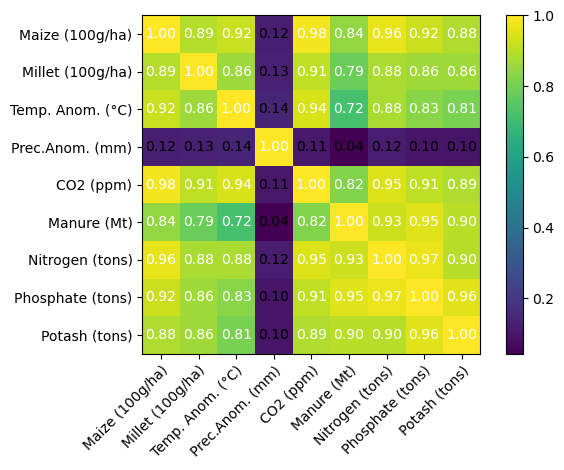

In [16]:
from mlxtend.plotting import heatmap
cm = np.corrcoef(global_crop_yield_df.values.T)
hm = heatmap(cm, row_names=global_crop_yield_df.columns, column_names=global_crop_yield_df.columns)
plt.tight_layout()
plt.show()

## Train, validation, and test sets
The data used to train a model of the ensemble is divided into a train set and a test set. The test set is used after the training to test the performance of the model to predict the values. The train set is divided into two subsets: one subset, that is the final training set, and the validation set used during the training phase to update the model's parameters. 

In [17]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=0)
X_train_temp.shape, y_train_temp.shape, X_test.shape, y_test.shape

((49, 4), (49, 1), (13, 4), (13, 1))

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=1)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((39, 4), (39, 1), (10, 4), (10, 1))

## Neural network training

In [19]:
num_observations = X.shape[0]
num_observations

62

We train an ensemble of MLP models that start with a different init parameters

In [20]:
import random 
num_ensemble_members = 20 
from random import randint
random_states = [randint(2, num_observations) for p in range(1, num_ensemble_members + 1)]
len(random_states)

20

A random state is the seed used during the training of a model of the ensemble

In [21]:
random_states[:]

[21, 35, 7, 36, 60, 19, 52, 56, 35, 16, 43, 58, 8, 23, 25, 36, 55, 35, 45, 47]

We initialize a 2D array that will contain the predictions of the ensemble models

In [22]:
ensemble_members = np.zeros((num_observations,num_ensemble_members))
ensemble_members.shape

(62, 20)

In [23]:
#from sklearn.pipeline import make_pipeline
for i in range(0, num_ensemble_members):
    random_state = random_states[i]
    tic = time()
    mlp_model = MLPRegressor(
               hidden_layer_sizes=(4, 1),
               activation='tanh',
               #learning_rate_init=0.01, not used with lbfgs solver
               early_stopping=True,
               random_state=random_state,
               solver='lbfgs',
               max_iter=20
            )
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=random_state)
    mlp_model.fit(X_train, y_train)
    model_sample = mlp_model.predict(X_scaled)
    ensemble_members[:, i] = model_sample
    print('Run {0:d}'.format(i))
    print(f"done in {time() - tic:.3f}s")
    print(f"Train R2 score: {mlp_model.score(X_train, y_train):.2f}")
    print(f"Validation R2 score: {mlp_model.score(X_val, y_val):.2f}\n")
    mlp_model=None

Run 0
done in 0.024s
Train R2 score: 0.96
Validation R2 score: 0.98

Run 1
done in 0.013s
Train R2 score: 0.99
Validation R2 score: 0.92

Run 2
done in 0.012s
Train R2 score: 0.98
Validation R2 score: 0.93

Run 3
done in 0.014s
Train R2 score: 0.98
Validation R2 score: 0.95

Run 4
done in 0.042s
Train R2 score: 0.97
Validation R2 score: 0.96

Run 5
done in 0.023s
Train R2 score: 0.96
Validation R2 score: 0.94

Run 6
done in 0.015s
Train R2 score: 0.98
Validation R2 score: 0.89

Run 7
done in 0.015s
Train R2 score: 0.97
Validation R2 score: 0.98

Run 8
done in 0.017s
Train R2 score: 0.99
Validation R2 score: 0.92

Run 9
done in 0.012s
Train R2 score: 0.97
Validation R2 score: 0.95

Run 10
done in 0.012s
Train R2 score: 0.94
Validation R2 score: 0.96

Run 11
done in 0.012s
Train R2 score: 0.98
Validation R2 score: 0.95

Run 12
done in 0.011s
Train R2 score: 0.97
Validation R2 score: 0.98

Run 13
done in 0.014s
Train R2 score: 0.97
Validation R2 score: 0.95

Run 14
done in 0.033s
Train R2

In [24]:
ensemble_members.shape

(62, 20)

## Inverse transform
We denormalize the predictions by inverting the predicted values. We can perform the inverse transform using a simple equation

In [25]:
ensemble_denorm = ensemble_members * variance_y + mean_y
#ensemble_denorm[:,0]

or we can use the function provided by the scaler

In [26]:
prediction = scaler_y.inverse_transform(ensemble_members)
#prediction[:, 0]

In [27]:
diff = prediction[:, 0] - ensemble_denorm[:,0] == 0
diff.all()

True

We compute the ensemble values

In [29]:
ensemble = prediction.sum(axis=1) / num_ensemble_members
#ensemble

## Linear regression
We build a [linear regression](https://scikit-learn.org/stable/modules/linear_model.html) model to be used as a base reference to compare its performance against the MLP model.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=0)

In [63]:
linear_regr = linear_model.LinearRegression()
linear_regr.fit(X_train, y_train)
linear_predictions = linear_regr.predict(X_scaled)
linear_test_predictions = linear_regr.predict(X_test)
linear_predictions.shape

(62, 1)

In [64]:
linear_rmse = mean_squared_error(linear_test_predictions, y_test)
print('Root mean squared error: {:.2f}'.format(linear_rmse))

Root mean squared error: 0.04


In [65]:
linear_coeffs = linear_regr.coef_
print('Linear regression coefficients: {}'.format(linear_coeffs))

Linear regression coefficients: [[ 0.22364994 -0.00859665 -0.2351202   0.9961228 ]]


In [66]:
predictions = scaler_y.inverse_transform(linear_predictions)

## Ensemble and best model visualization
We use the ensemble 16 with the best test R2 score

In [67]:
#best_model_predictions = prediction[:, 1]

In [68]:
#model_sample_best = predictions_denorm.iloc[:, 16]
#model_sample_best[:2]

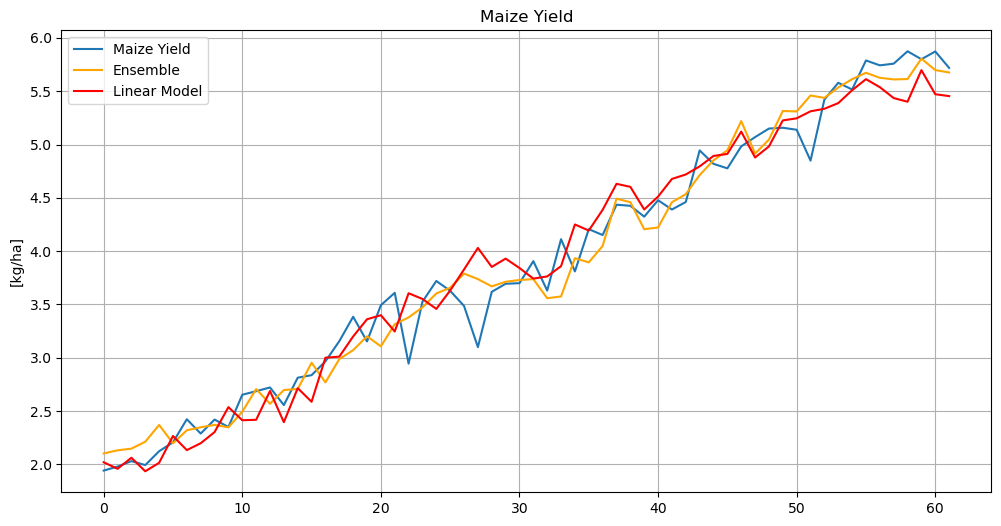

In [69]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Maize Yield')
ax.set_ylabel('[kg/ha]');
ax.grid(True, which='both')
#ax.set_xticks(predictions_denorm.index)
#ax.set_xticklabels(predictions_denorm.index, rotation=70)
#ax.xaxis.set_major_locator(dates.YearLocator(5))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#maize_yield = global_crop_yield_df['Maize (100g/ha)'] / 10000 
pd_maize_yield, = plt.plot(y / 10000, label='Maize Yield')
#pd_predictions_best, = plt.plot(best_model_predictions / 10000, label='Best model', color='green')
pd_ensemble, = plt.plot(ensemble / 10000, label='Ensemble', color='orange')
pd_linear, = plt.plot(predictions / 10000, label='Linear Model', color='red')
plt.legend(handles=[pd_maize_yield, pd_ensemble, pd_linear], loc='upper left')